Installing libraries and pretrained BERT model.

In [1]:
!pip install gpustat transformers

     |████████████████████████████████| 78 kB 2.5 MB/s 
     |████████████████████████████████| 4.0 MB 9.7 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 895 kB 43.2 MB/s 
     |████████████████████████████████| 596 kB 43.4 MB/s 
     |████████████████████████████████| 6.6 MB 42.3 MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-py3-none-any.whl size=12617 sha256=44334aa8be096405f238d0df1a4790aef4b702e8eebc47dda094afa405f46673
  Stored in directory: /root/.cache/pip/wheels/e6/67/af/f1ad15974b8fd95f59a63dbf854483ebe5c7a46a93930798b8
Successfully built gpustat
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Confirm GPU is detected

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Importing required libraries

In [3]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
# import transformers
import pandas as pd
import io
import numpy as np
import random
import matplotlib.pyplot as plt
# from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, BertConfig, BertForTokenClassification, get_scheduler
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [4]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(device)

cuda


In [5]:
MODEL = 'bert-base-uncased'

In [6]:
train_url = 'https://raw.githubusercontent.com/cambridgeltl/MTL-Bioinformatics-2016/master/data/JNLPBA-IOBES/train.tsv'

In [7]:
test_url = 'https://raw.githubusercontent.com/cambridgeltl/MTL-Bioinformatics-2016/master/data/JNLPBA-IOBES/test.tsv'

In [8]:
df_train = pd.read_csv(train_url, sep = '\t', header=None)
df_test = pd.read_csv(test_url, sep = '\t', header=None)
df_train.columns = ['Word', 'Tag']
df_test.columns = ['Word', 'Tag']

In [ ]:
print(df_train.shape)
df_train.head()

(445090, 2)


,Word,Tag
0,IL-2,B-DNA
1,gene,E-DNA
2,expression,O
3,and,O
4,NF-kappa,B-protein


In [9]:
df_train = df_train.dropna()
df_test = df_test.dropna()
train_data = list(zip(df_train['Word'], df_train['Tag']))
test_data = list(zip(df_test['Word'], df_test['Tag']))

In [10]:
def prepare_data(data):
  sentences = []
  tags = []
  sent = []
  sent_tags = []
  for word, tag in data:
    if word != '.':
      sent.append(word)
      sent_tags.append(tag)
    else:
      sent.append(word)
      sent_tags.append(tag)
      # sent.insert(0,'[CLS]')
      # sent.append('[SEP]')
      # sent_tags.insert(0, 'O')
      # sent_tags.append('O')
      sentences.append(sent)
      tags.append(sent_tags)
      sent = []
      sent_tags = []
  return sentences, tags

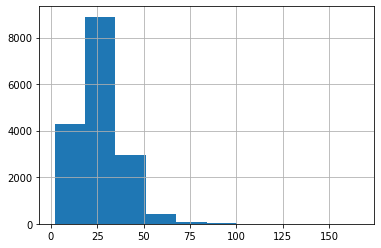

In [11]:
training_sentences, training_tags = prepare_data(train_data)
sent_len = [len(sent) for sent in training_sentences]
pd.Series(sent_len).hist()

In [ ]:
# unique_labels = []
# for sent_tags in training_tags:
#   for label in sent_tags:
#     match = re.match(".\-(.*)", label)
#     if match and match.group(1) not in unique_labels:
#       unique_labels.append(match.group(1))
#     elif (match is None) and (label not in unique_labels):
#       unique_labels.append(label)
# print('labels: ', unique_labels)

labels:  ['DNA', 'O', 'protein', 'cell_type', 'cell_line', 'RNA']


In [12]:
max_len = max([len(sent) for sent in training_sentences])
tag_to_idx = {}
for sent_tags in training_tags:
  for label in sent_tags:
    if label not in tag_to_idx:
      tag_to_idx[label] = len(tag_to_idx)
idx_to_tag = {idx:tag for tag, idx in tag_to_idx.items()}
print(tag_to_idx)
print(max_len)

{'B-DNA': 0, 'E-DNA': 1, 'O': 2, 'B-protein': 3, 'E-protein': 4, 'S-protein': 5, 'I-protein': 6, 'B-cell_type': 7, 'I-cell_type': 8, 'E-cell_type': 9, 'I-DNA': 10, 'S-cell_type': 11, 'S-DNA': 12, 'S-cell_line': 13, 'B-cell_line': 14, 'E-cell_line': 15, 'I-cell_line': 16, 'B-RNA': 17, 'I-RNA': 18, 'E-RNA': 19, 'S-RNA': 20}
166


In [13]:
training_tags_ids = [[tag_to_idx[tag] for tag in sent_tags] for sent_tags in training_tags]
print(training_tags_ids[0])

[0, 1, 2, 2, 3, 4, 2, 2, 5, 2, 2, 2, 2, 2, 5, 2]


In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)
# tokenized_sents = [tokenizer(sent, is_split_into_words=True) for sent in training_sentences]
# print(tokenized_sents[0])

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
# tokenized_sents_tokens = [tokenizer.convert_ids_to_tokens(tokenized_sent['input_ids']) for tokenized_sent in tokenized_sents]
# print(tokenized_sents_tokens[0])

['[CLS]', 'il', '-', '2', 'gene', 'expression', 'and', 'n', '##f', '-', 'kappa', 'b', 'activation', 'through', 'cd', '##28', 'requires', 'reactive', 'oxygen', 'production', 'by', '5', '-', 'lip', '##ox', '##y', '##genase', '.', '[SEP]']


In [15]:
def align_tags(data_tags, data_sents_encoded):
  ner_tags = []
  for idx, tag in enumerate(data_tags):
    word_ids = data_sents_encoded[idx].word_ids()
    previous_word_idx = None
    tag_ids = []
    for word_id in word_ids:
      if word_id is None:
        tag_ids.append(-100)
      elif word_id != previous_word_idx:
        tag_ids.append(tag[word_id])
      else:
        tag_ids.append(-100)
      previous_word_idx = word_id
    ner_tags.append(tag_ids)
  return ner_tags


In [16]:
MAX_LEN = 512
sents_encoded = [tokenizer(sent, is_split_into_words=True, padding='max_length', truncation=True, max_length=MAX_LEN) for sent in training_sentences]
tags_encoded = align_tags(training_tags_ids, sents_encoded)
for i, sent_tags in enumerate(tags_encoded):
  sents_encoded[i]['labels'] = sent_tags
# print(tags_encoded[0])
# print(sents_encoded[0])
# print(len(sents_encoded[0]['input_ids']))

In [17]:
train_data, test_data = train_test_split(sents_encoded, test_size=0.2)
# print(train_data[0])
# print(len(train_data), len(test_data))

In [18]:
train_inputs = []
test_inputs = []
train_masks = []
test_masks = []
train_tags = []
test_tags = []
for train_item in train_data:
  train_inputs.append(train_item['input_ids'])
  train_masks.append(train_item['attention_mask'])
  train_tags.append(train_item['labels'])
for test_item in test_data:
  test_inputs.append(test_item['input_ids'])
  test_masks.append(test_item['attention_mask'])
  test_tags.append(test_item['labels'])
print(test_tags[0])

[-100, 2, 2, 2, 5, -100, -100, -100, 2, -100, -100, -100, 2, 2, -100, 2, 2, -100, 2, 2, -100, 2, 2, -100, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

In [19]:
# convert training and test data to tensors
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)
train_tags = torch.tensor(train_tags)
test_tags = torch.tensor(test_tags)
train_masks = torch.tensor(train_masks)
test_masks = torch.tensor(test_masks)

In [20]:
batch_size = 6
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [21]:
model = BertForTokenClassification.from_pretrained(MODEL, num_labels=len(tag_to_idx))
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [23]:
n_epochs = 1
learning_rate = 1e-05
MAX_GRAD_NORM = 10
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
# num_training_steps = n_epochs * len(train_dataloader)
# lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [ ]:
# del model
# torch.cuda.empty_cache()

In [24]:
for epoch in range(n_epochs):
  tr_loss, tr_accuracy = 0, 0
  tr_examples, tr_steps = 0, 0
  tr_preds, tr_labels = [], []
  model.train()
  for idx, batch in enumerate(train_dataloader):
    b_ids = batch[0].to(device)
    b_mask = batch[1].to(device)
    b_tags = batch[2].to(device)
    loss, tr_logits = model(input_ids=b_ids, attention_mask=b_mask, labels=b_tags, return_dict=False)
    tr_loss += loss.item()
    tr_steps += 1
    tr_examples += b_tags.size(0)

    if idx % 200==0:
      loss_step = tr_loss/tr_steps
      print("Training loss per 200 training steps: ",loss_step)

    flattened_targets = b_tags.view(-1) 
    active_logits = tr_logits.view(-1, model.num_labels) 
    flattened_predictions = torch.argmax(active_logits, axis=1)

    active_accuracy = b_tags.view(-1) != -100 
        
    labels = torch.masked_select(flattened_targets, active_accuracy)
    predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
    tr_labels.extend(labels)
    tr_preds.extend(predictions)

    tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
    tr_accuracy += tmp_tr_accuracy
    
    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=MAX_GRAD_NORM)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = tr_loss / tr_steps
  tr_accuracy = tr_accuracy / tr_steps
  print("Training loss epoch: ", epoch_loss)
  print("Training accuracy epoch: ", tr_accuracy)

Training loss per 200 training steps:  3.2351157665252686
Training loss per 200 training steps:  0.9633135094274929
Training loss per 200 training steps:  0.7387943976091922
Training loss per 200 training steps:  0.6249791664906628
Training loss per 200 training steps:  0.5485303619557924
Training loss per 200 training steps:  0.4962482844832001
Training loss per 200 training steps:  0.4585158568678996
Training loss per 200 training steps:  0.4309847380867564
Training loss per 200 training steps:  0.40694761344887254
Training loss per 200 training steps:  0.3894160428642399
Training loss per 200 training steps:  0.37243870887225833
Training loss per 200 training steps:  0.35842023170919163
Training loss epoch:  0.3567634904163037
Training accuracy epoch:  0.8982714502588036


In [25]:
model.eval()
eval_loss, eval_accuracy = 0, 0
eval_examples, eval_steps = 0, 0
eval_preds, eval_labels = [], []
with torch.no_grad():
  for idx, batch in enumerate(test_dataloader):
    test_ids = batch[0].to(device)
    test_mask = batch[1].to(device)
    test_tags = batch[2].to(device)

    loss, pred_output = model(input_ids=test_ids, attention_mask=test_mask, labels=test_tags, return_dict=False)
    
    eval_loss += loss.item()
    eval_steps += 1
    eval_examples += test_tags.size(0)

    if idx % 200==0:
      loss_step = eval_loss/eval_steps
      print("Validation loss per 200 training steps: ",loss_step)

    flattened_targets = test_tags.view(-1) 
    active_logits = pred_output.view(-1, model.num_labels) 
    flattened_predictions = torch.argmax(active_logits, axis=1) 

    active_accuracy = test_tags.view(-1) != -100 

    labels = torch.masked_select(flattened_targets, active_accuracy)
    predictions = torch.masked_select(flattened_predictions, active_accuracy)

    eval_labels.extend(labels)
    eval_preds.extend(predictions)
    tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
    eval_accuracy += tmp_eval_accuracy

  labels = [idx_to_tag[id.item()] for id in eval_labels]
  predictions = [idx_to_tag[id.item()] for id in eval_preds]

  eval_loss = eval_loss / eval_steps
  eval_accuracy = eval_accuracy / eval_steps
  print("Validation Loss: ",eval_loss)
  print("Validation Accuracy: ",eval_accuracy)

Validation loss per 200 training steps:  0.1886027455329895
Validation loss per 200 training steps:  0.209852158504339
Validation loss per 200 training steps:  0.20411368916066655
Validation Loss:  0.20614642052973087
Validation Accuracy:  0.9340203677888758


In [26]:
!pip install seqeval[gpu]

     |████████████████████████████████| 43 kB 1.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=33f5c40da1c6ba50360041efddd823e5e6ce5101bfab827eaada101bc0bd5168
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [27]:
from seqeval.metrics import classification_report
labels = [labels]
predictions = [predictions]
print(classification_report(labels,predictions))

              precision    recall  f1-score   support

         DNA       0.63      0.73      0.68      1751
         RNA       0.68      0.78      0.72       163
   cell_line       0.63      0.59      0.61       665
   cell_type       0.69      0.81      0.74      1194
     protein       0.75      0.85      0.80      5621

   micro avg       0.71      0.80      0.75      9394
   macro avg       0.67      0.75      0.71      9394
weighted avg       0.71      0.80      0.75      9394

